In [1]:
! pip install pyheif

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 55.1 MB/s eta 0:00:00a 0:00:01


In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import pyheif
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# !mkdir images
# !cd images

# !wget https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg
# !wget https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg

In [4]:
# desired size of the output image
imsize = 256 if torch.cuda.is_available() else 128  # use small size if no gpu
# imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu
# imsize = 1024 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor

# additional code to work with iphone .heic format
def work_with_image(file_path):
    # Check if image format is .heic
    if file_path.split('.')[-1] in ['heic', 'HEIC']:
        heif_file = pyheif.read(file_path)
        image = Image.frombytes(heif_file.mode, heif_file.size,
                                heif_file.data, "raw", heif_file.mode,
                                heif_file.stride)
    # .png images can have 4 channels: one is "alpha" or transparency
    elif file_path.split('.')[-1] in ['png']:
        image = Image.open(file_path).convert('RGB')
    else:  # assume "normal" image that pillow can open
        image = Image.open(file_path)
    return image


def image_loader(image_name):
    image = work_with_image(image_name)
    # image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


# style_img = image_loader("./images/picasso.jpg")
style_img = image_loader("./images/chamonix.png")[:,:,:512*2,:]
style_img = image_loader("./images/cham_no_shadows.jpg")[:,:,:256*4,:]
# style_img = image_loader("./images/Monet-Camille.jpg")[:,:,:,111:]
# style_img = image_loader("./images/dark-skull.jpg")[:,:,:,100:612]
# style_img = image_loader("./images/scary_rider.jpg")[:,:,85:,:]
style_img = image_loader("./images/girl-flowers.jpg")[:,:,:,128*2:640*2]
style_img = image_loader("./images/girl_hydrangers.jpeg")[:,:,:,293:]
style_img = image_loader("./images/cartoon_girl_flowers.jpg")[:,:,:256,:]
content_img = image_loader("./images/felix_ronnie.HEIC")[:,:,30*8:158*8,:]
content_img = image_loader("./images/mimi_mollie.HEIC")[:,:,:,682-512:]
content_img = image_loader("./images/chair.HEIC")[:,:,:,(682-512)*2+1:]
content_img = image_loader("./images/emily_ski.HEIC")[:,:,:,:1024]
content_img = image_loader("./images/tom.HEIC")[:,:,:,:1024]
content_img = image_loader("./images/emily_stand.JPG")[:,:,:,1365-1024:]
content_img = image_loader("./images/tom_james.JPG")[:,:,:,171:1195]
content_img = image_loader("./images/mimi_flowers.heic")[:,:,25*1:281*1,:]
# content_img = image_loader("./images/mimi_flowers.heic")[:,:,:,:]
# content_img = image_loader("./images/dancing.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

In [5]:
style_img.size(), content_img.size()

(torch.Size([1, 3, 256, 256]), torch.Size([1, 3, 256, 256]))

In [6]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

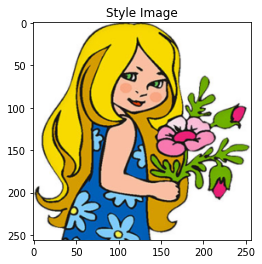

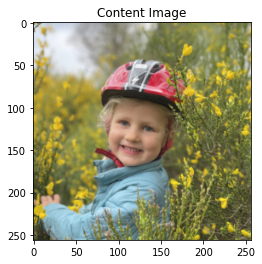

In [7]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [8]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [9]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [10]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [11]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [12]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

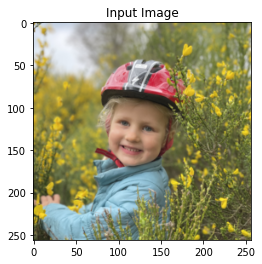

In [98]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [76]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [189]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1, save_every=10):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    imgs = []
    while run[0] <= num_steps:
        
        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()
            
            if run[0] % save_every == 0:
                im = input_img.detach().clone().clamp_(0,1).cpu().squeeze(0).permute(1,2,0)
                imgs.append(im)       
                
            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img, imgs

Building the style transfer model..
Optimizing..


/tmp/ipykernel_19005/1744401072.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/tmp/ipykernel_19005/1744401072.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 22589.824219 Content Loss: 49.325512

run [100]:
Style Loss : 8610.564453 Content Loss: 55.478111

run [150]:
Style Loss : 4795.848633 Content Loss: 58.922333

run [200]:
Style Loss : 6181.697754 Content Loss: 59.256245

run [250]:
Style Loss : 2236.750488 Content Loss: 62.067787

run [300]:
Style Loss : 1783.172729 Content Loss: 63.421715

run [350]:
Style Loss : 1573.127563 Content Loss: 64.457329

run [400]:
Style Loss : 1420.097412 Content Loss: 65.054482

run [450]:
Style Loss : 1274.122681 Content Loss: 66.053467

run [500]:
Style Loss : 26077.337891 Content Loss: 65.058945

run [550]:
Style Loss : 30440.580078 Content Loss: 64.835892

run [600]:
Style Loss : 6428.717285 Content Loss: 66.549545

run [650]:
Style Loss : 1305.294922 Content Loss: 69.866272

run [700]:
Style Loss : 1054.041504 Content Loss: 70.198631

run [750]:
Style Loss : 2201.326660 Content Loss: 72.099075

run [800]:
Style Loss : 1177.366821 Content Loss: 71.932686

run [850]:
Style Loss 

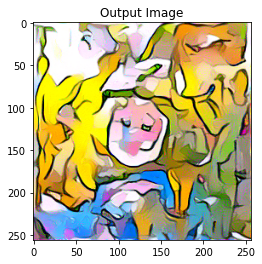

In [275]:
input_img = content_img.clone()
SAVE_EVERY = 25
output, evolution = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=SAVE_EVERY*11*4,
                            style_weight=10000000, content_weight=1, save_every=SAVE_EVERY)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [276]:
len(evolution)

45

IndexError: list index out of range

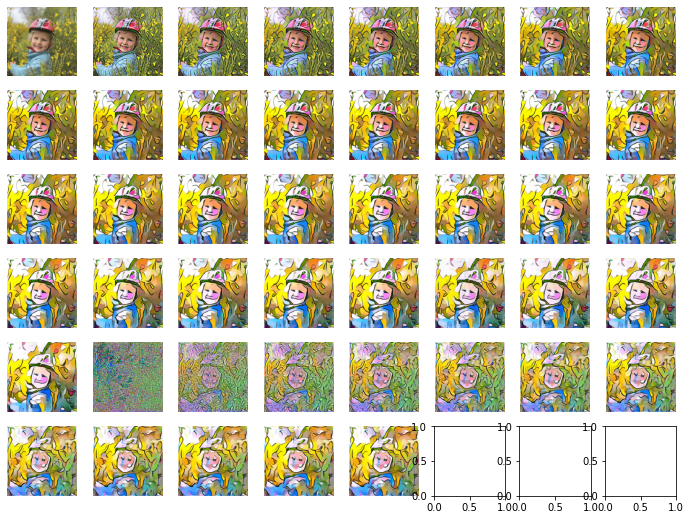

In [277]:
fig, axs = plt.subplots(3*2,4*2,figsize=(12,9)
                       )
for i, ax in enumerate(axs.flatten()):
    ax.imshow(evolution[i])
    ax.axis('off')

plt.tight_layout()
plt.show()

In [282]:
import matplotlib.animation as animation
import numpy as np

fig, ax = plt.subplots(figsize=(4, 4))
frame = 0
evol = torch.stack(evolution, dim=0).numpy()

im = plt.imshow(evol[frame])

def init():
    im = plt.imshow(evol[0])
    return im,

def update(frame):
    im.set_array(evol[frame])
    return im,

ani = animation.FuncAnimation(fig, update, frames=list(range(evol.shape[0])),
                             init_func=init, blit=True)
plt.show()


<IPython.core.display.Javascript object>

In [274]:
evolution.shape

(45,)

In [283]:
evo_dict = dict(zip(range(len(evolution)), evolution))
with open(mimiP/'evo3.pkl', 'wb') as f:
    pickle.dump(evo_dict, f)

In [142]:
# im1 = output.detach().clone()
im2 = output.detach().clone()
# im3 = output.detach().clone()
# im4 = output.detach().clone()
# im5 = output.detach().clone()
# im6 = output.detach().clone()
# im7 = output.detach().clone()
# im20 = output.detach().clone()

In [143]:
import pickle
from pathlib import Path

mimiP = Path('./images/mimi_processed')
mimiP.mkdir(exist_ok=True)

with open(mimiP/'im2.pkl', 'wb') as f:
    pickle.dump(im2, f)

num_files = 20
imgs = [None] * num_files
for i in range(1,num_files+1):
    with open(mimiP/'im{}.pkl'.format(i), 'rb') as f:
        imgs[i-1] = pickle.load(f)
    
# plt.figure()
# imshow(temp)

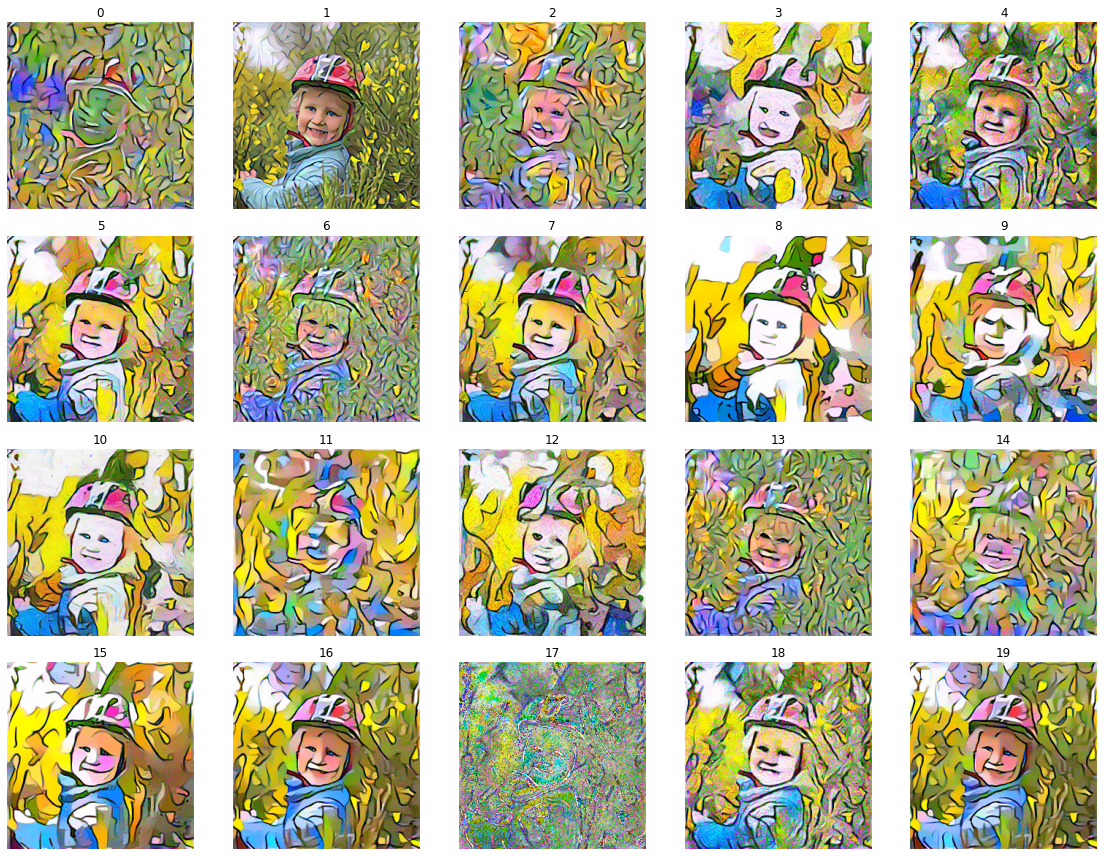

In [144]:
fig, axs = plt.subplots(4,5,figsize=(16,12)
                       )
# imgs = (im1, im2, im3, im4, im5, im6)
imshow_ims = [None] * 20
for i, im in enumerate(imgs):
    imshow_ims[i] = im.cpu().squeeze(0).permute(1,2,0).numpy()

for i, ax in enumerate(axs.flatten()):
    ax.imshow(imshow_ims[i])
    ax.set_title(i)
    ax.axis('off')

plt.tight_layout()
plt.show()

# sphinx_gallery_thumbnail_number = 4
# plt.ioff()
# plt.show()

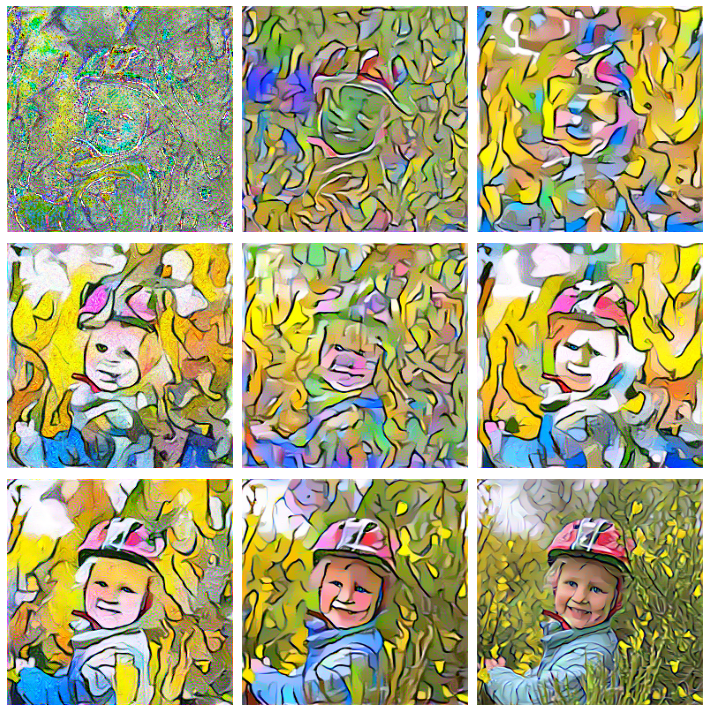

In [145]:
mask = [17, 0, 11, 12, 14, 9, 5, 19, 1]
imshow_ims2 = [imshow_ims[m] for m in mask]

fig, axs = plt.subplots(3,3,figsize=(10,10)
                       )
for i, ax in enumerate(axs.flatten()):
    ax.imshow(imshow_ims2[i])
    ax.axis('off')

plt.tight_layout()
plt.show()

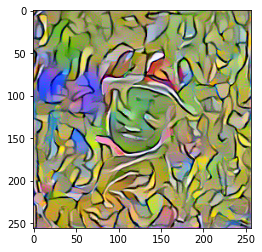

In [48]:
plt.imshow(im1.cpu().squeeze(0).permute(1,2,0))